<a href="https://colab.research.google.com/github/marendtz/ModelNER/blob/master/XLMR_finetune_pan_and_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [2]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom')
  shutil.rmtree('/content/ray_results')
except:
  print("no such folder")

no such folder


In [3]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [5]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
rm: cannot remove '/content/*': No such file or directory
total 16
drwxr-xr-x 1 root root 4096 Jun 16 14:26 ./
drwxr-xr-x 1 root root 4096 Jun 16 13:50 ../
drwxr-xr-x 4 root root 4096 Jun 14 18:26 .config/


'/content'

In [6]:
# clone github repo
!git clone https://{token}@github.com/marendtz/ModelNER.git

Cloning into 'ModelNER'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 84 (delta 47), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (84/84), 1.23 MiB | 2.48 MiB/s, done.


In [7]:
# check python version
!python --version

Python 3.10.12


In [8]:
# install dependencies
%pip install -r /content/ModelNER/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# adjust pickle version used, since different version throws error with ray backend for hyperparameter optimization
!pip install pickle5==0.0.10
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Get and Analyze dataset from Huggingface**

In [11]:
# login to HugginFace to enable upload of model
notebook_login()

In [22]:
# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...

ds = load_dataset("maren-hugg/sustainability_ner")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


**Prepare input data for following training of the model XLMRobertaForTokenClassification (with our config=labels, device, ...)**

In [13]:
# prepare dataset
ds_custom = ds
print("Example element in Custom Dataset:")
ds_custom_element = ds["train"][1]
for key, value in ds_custom_element.items():
    print(f"{key}: {value}")

Example element in Custom Dataset:
ner_tags: [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]
tokens: ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']


In [14]:
# show info about tag feature --> we already defined the varibale tags earlier
# --> DatasetDict holds information about all features used (like infos on columns in dataframe)
print('----------features----------------')
print(ds_custom["train"].features)
print('----------feature ner_tags----------------')
print(ds_custom["train"].features["ner_tags"].feature)


----------features----------------
{'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
----------feature ner_tags----------------
ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [15]:
# examples
print(ds_custom["train"][1])
print(ds_custom["train"][1]["tokens"])
print(ds_custom["train"][1]["ner_tags"])

{'ner_tags': [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0], 'tokens': ['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']}
['Porsche', 'AG', 'is', 'also', 'a', 'member', 'of', 'the', 'employers', "'", 'association', 'Suedwestmetall', 'and', 'is', 'therefore', 'part', 'of', 'the', 'social', 'partnership', 'actively', 'practiced', 'between', 'the', 'metal', 'and', 'electrical', 'industry', 'and', 'the', 'IG', 'Metall', 'trade', 'union', '.']
[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0]


Count PER-Tag: 91
Count ORG-Tag: 1716
Count LOC-Tag: 629


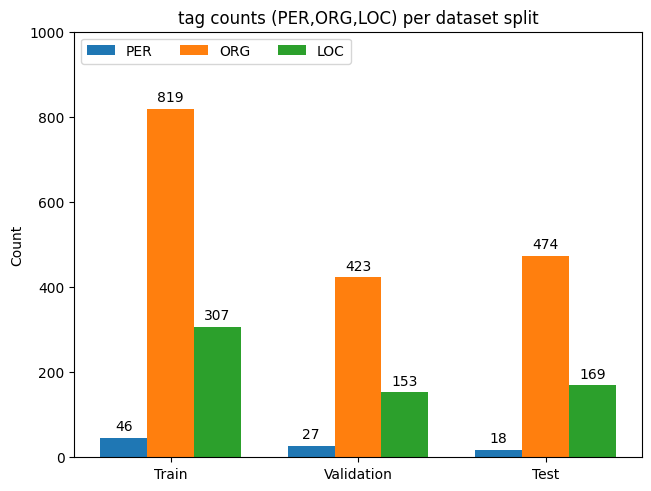

In [16]:
# getting info about tag-counts of labeled data
count_per = 0
count_org = 0
count_loc = 0
for sentence in ds_custom["train"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
train_count_per= count_per
train_count_org= count_org
train_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["validation"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
val_count_per= count_per
val_count_org= count_org
val_count_loc= count_loc

count_per = 0
count_org = 0
count_loc = 0

for sentence in ds_custom["test"]:
  tags = sentence["ner_tags"]
  count_per = count_per + tags.count(1)
  count_org = count_org + tags.count(3)
  count_loc = count_loc + tags.count(5)
test_count_per= count_per
test_count_org= count_org
test_count_loc= count_loc


print(f"Count PER-Tag: {train_count_per+val_count_per+test_count_per}")
print(f"Count ORG-Tag: {train_count_org+val_count_org+test_count_org}")
print(f"Count LOC-Tag: {train_count_loc+val_count_loc+test_count_loc}")

splits = ("Train", "Validation", "Test")
split_values = {
    'PER': (train_count_per, val_count_per, test_count_per),
    'ORG': (train_count_org, val_count_org, test_count_org),
    'LOC': (train_count_loc, val_count_loc, test_count_loc),
}

x = np.arange(len(splits))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in split_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('tag counts (PER,ORG,LOC) per dataset split')
ax.set_xticks(x + width, splits)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1000)

plt.show()

**Set tokenizer**

In [17]:
# setup for tokenization
xlmr_model_name = "maren-hugg/xlm-roberta-base-finetuned-panx-en"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [18]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_ds_custom_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['ner_tags', 'tokens'])



In [19]:
# encode dataset
ds_custom_encoded = encode_ds_custom_dataset(ds_custom)
print("Encoded example:")
print(ds_custom_encoded["train"][1])

Encoded example:
{'input_ids': [0, 81201, 24639, 83, 2843, 10, 32786, 111, 70, 143889, 7, 242, 125413, 1832, 297, 25617, 185790, 136, 83, 127298, 2831, 111, 70, 2265, 165410, 36457, 538, 41361, 71, 17721, 70, 12924, 136, 39108, 289, 53099, 136, 70, 79883, 94492, 52350, 69941, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 4, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 3, -100, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, 4, 0, 0, 0, -100, -100]}


**Define performance measures**

In [81]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists


# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": accuracy_score(y_true, y_pred)
          #"classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2) # throws error within parameter optimization
          }


**Finetuning XLM-RoBERTa and Upload to Huggingface**

In [82]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [83]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
num_epochs = 3
batch_size = 24
learning_rate = 5e-5
weight_decay= 0.01

logging_steps = len(ds_custom_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-custom"
training_args = TrainingArguments(output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="steps", eval_steps=batch_size, # Number of update steps between two evaluations if evaluation_strategy="steps".
                                  save_strategy="steps", save_steps=1e6,
                                  learning_rate=learning_rate, #  The initial learning rate for AdamW optimizer.
                                  weight_decay=weight_decay, # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
                                  disable_tqdm=False,
                                  logging_strategy="steps", logging_steps=batch_size,  # Number of update steps between two logs if logging_strategy="steps".
                                  push_to_hub=True)

In [84]:
# this model needs to be created at huggingface:
f"{xlmr_model_name}-custom"

'maren-hugg/xlm-roberta-base-finetuned-panx-en-custom'

In [85]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [86]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [87]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_custom_encoded["train"],
                  eval_dataset=ds_custom_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

/content/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom is already a clone of https://huggingface.co/maren-hugg/xlm-roberta-base-finetuned-panx-en-custom. Make sure you pull the latest changes with `repo.git_pull()`.


In [88]:
# optimize hyperparameters
# default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray import tune

tune_config = {
        "per_device_train_batch_size": tune.choice([16, 32, 64]),
        "per_device_eval_batch_size": tune.choice([16, 32, 64]),
        "num_train_epochs": tune.choice([2, 3, 4, 5]),
        "learning_rate":  tune.uniform(1e-5, 5e-5),
        "weight_decay":tune.uniform(0.0, 0.3)
    }

current_best_params = [{
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": 3,
    "learning_rate":  4.3918345266035816e-05,
    "weight_decay": 0.08486048763759228
}]

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    n_trials=20, # number of trials
    hp_space=lambda _: tune_config,
    # see: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.hyperopt.HyperOptSearch.html
    search_alg=HyperOptSearch(metric="objective", mode="max" ,points_to_evaluate=current_best_params),
    scheduler=ASHAScheduler(metric="objective", mode="max"),
    storage_path="/content/ray_results/",
    log_to_file=True
)

== Status ==
Current time: 2023-06-16 15:44:07 (running for 00:00:00.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 1/20 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_43bea735 | PENDI

(raylet) Spilled 3201 MiB, 3 objects, write throughput 214 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


== Status ==
Current time: 2023-06-16 15:44:28 (running for 00:00:20.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 1/20 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_43bea735 | PENDI

(pid=33256) 2023-06-16 15:44:36.997372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:44:38 (running for 00:00:30.90)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 1/20 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |       |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_43bea735 | PENDI

(_objective pid=33256) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=33256)   warnings.warn(
  0%|          | 0/96 [00:00<?, ?it/s]
(_objective pid=33256) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 17%|█▋        | 16/96 [00:02<00:09,  8.57it/s]


== Status ==
Current time: 2023-06-16 15:44:58 (running for 00:00:51.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name          | status   | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                     |          |                   |                 |                    |                 h_size |                ch_size |                |
|---------------------+----------+-------------------+-----------------+--------------------+------------------------+-------------

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=33256) {'loss': 0.1329, 'learning_rate': 3.2938758949526863e-05, 'epoch': 0.75}


(_objective pid=33256) 
 25%|██▌       | 4/16 [00:00<00:00, 34.92it/s]
(_objective pid=33256) 
 50%|█████     | 8/16 [00:00<00:00, 35.60it/s]
(_objective pid=33256) 
 75%|███████▌  | 12/16 [00:00<00:00, 36.60it/s]


Result for _objective_43bea735:
  date: 2023-06-16_15-45-00
  done: false
  epoch: 0.75
  eval_accuracy: 0.9686996238581408
  eval_f1: 0.8470776621297037
  eval_loss: 0.11593306809663773
  eval_precision: 0.8188854489164087
  eval_recall: 0.8772802653399668
  eval_runtime: 0.6143
  eval_samples_per_second: 406.934
  eval_steps_per_second: 26.044
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.51194300024422
  pid: 33256
  time_since_restore: 20.95837378501892
  time_this_iter_s: 20.95837378501892
  time_total_s: 20.95837378501892
  timestamp: 1686930300
  training_iteration: 1
  trial_id: 43bea735
  
(_objective pid=33256) {'eval_loss': 0.11593306809663773, 'eval_f1': 0.8470776621297037, 'eval_precision': 0.8188854489164087, 'eval_recall': 0.8772802653399668, 'eval_accuracy': 0.9686996238581408, 'eval_runtime': 0.6143, 'eval_samples_per_second': 406.934, 'eval_steps_per_second': 26.044, 'epoch': 0.75}


                                               
100%|██████████| 16/16 [00:00<00:00, 36.60it/s]
                                               
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=33256) {'loss': 0.0735, 'learning_rate': 2.1959172633017908e-05, 'epoch': 1.5}


(_objective pid=33256) 
 31%|███▏      | 5/16 [00:00<00:00, 42.41it/s]
(_objective pid=33256) 
 62%|██████▎   | 10/16 [00:00<00:00, 34.19it/s]
(_objective pid=33256) 
 88%|████████▊ | 14/16 [00:00<00:00, 33.25it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 33.25it/s]
                                               
 51%|█████     | 49/96 [00:08<00:14,  3.26it/s]


(_objective pid=33256) {'eval_loss': 0.09967384487390518, 'eval_f1': 0.867430441898527, 'eval_precision': 0.8562197092084006, 'eval_recall': 0.87893864013267, 'eval_accuracy': 0.9754164427727029, 'eval_runtime': 0.628, 'eval_samples_per_second': 398.09, 'eval_steps_per_second': 25.478, 'epoch': 1.5}
== Status ==
Current time: 2023-06-16 15:45:03 (running for 00:00:56.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status   | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_d

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=33256) {'loss': 0.053, 'learning_rate': 1.0979586316508954e-05, 'epoch': 2.25}


(_objective pid=33256) 
 38%|███▊      | 6/16 [00:00<00:00, 48.45it/s]
(_objective pid=33256) 
 69%|██████▉   | 11/16 [00:00<00:00, 43.98it/s]


Result for _objective_43bea735:
  date: 2023-06-16_15-45-07
  done: false
  epoch: 2.25
  eval_accuracy: 0.9734013970983342
  eval_f1: 0.8664495114006515
  eval_loss: 0.09807615727186203
  eval_precision: 0.8512
  eval_recall: 0.8822553897180763
  eval_runtime: 0.4652
  eval_samples_per_second: 537.406
  eval_steps_per_second: 34.394
  hostname: e419f13e025b
  iterations_since_restore: 3
  node_ip: 172.28.0.12
  objective: 3.573306298217062
  pid: 33256
  time_since_restore: 28.22541618347168
  time_this_iter_s: 3.791693925857544
  time_total_s: 28.22541618347168
  timestamp: 1686930307
  training_iteration: 3
  trial_id: 43bea735
  
(_objective pid=33256) {'eval_loss': 0.09807615727186203, 'eval_f1': 0.8664495114006515, 'eval_precision': 0.8512, 'eval_recall': 0.8822553897180763, 'eval_accuracy': 0.9734013970983342, 'eval_runtime': 0.4652, 'eval_samples_per_second': 537.406, 'eval_steps_per_second': 34.394, 'epoch': 2.25}


(_objective pid=33256) 
                                               
100%|██████████| 16/16 [00:00<00:00, 42.90it/s]
                                               
 86%|████████▋ | 83/96 [00:12<00:01,  8.46it/s]


== Status ==
Current time: 2023-06-16 15:45:08 (running for 00:01:01.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status   | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |          |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+----------+-------------------+-----------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33256) 
 38%|███▊      | 6/16 [00:00<00:00, 50.31it/s]


(_objective pid=33256) {'loss': 0.0411, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=33256) 
 75%|███████▌  | 12/16 [00:00<00:00, 46.10it/s]
                                               
100%|██████████| 96/96 [00:14<00:00,  6.58it/s]


(_objective pid=33256) {'eval_loss': 0.10372860729694366, 'eval_f1': 0.8697042366107113, 'eval_precision': 0.8395061728395061, 'eval_recall': 0.9021558872305141, 'eval_accuracy': 0.9739387426114992, 'eval_runtime': 0.4435, 'eval_samples_per_second': 563.73, 'eval_steps_per_second': 36.079, 'epoch': 3.0}
(_objective pid=33256) {'train_runtime': 14.5923, 'train_samples_per_second': 102.794, 'train_steps_per_second': 6.579, 'train_loss': 0.07511878696580727, 'epoch': 3.0}
Result for _objective_43bea735:
  date: 2023-06-16_15-45-10
  done: true
  epoch: 3.0
  eval_accuracy: 0.9739387426114992
  eval_f1: 0.8697042366107113
  eval_loss: 0.10372860729694366
  eval_precision: 0.8395061728395061
  eval_recall: 0.9021558872305141
  eval_runtime: 0.4435
  eval_samples_per_second: 563.73
  eval_steps_per_second: 36.079
  experiment_tag: 1_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_decay=0.0849
  hostname: e419f13e025b
  iterations_si

(pid=33688) 2023-06-16 15:45:27.283387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:45:28 (running for 00:01:21.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 2/20 (1 PENDING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------------------

(_objective pid=33688) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=33688)   warnings.warn(
  0%|          | 0/16 [00:00<?, ?it/s]You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


== Status ==
Current time: 2023-06-16 15:45:44 (running for 00:01:36.43)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

 81%|████████▏ | 13/16 [00:05<00:00,  3.11it/s]


== Status ==
Current time: 2023-06-16 15:45:49 (running for 00:01:41.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=33688) {'train_runtime': 6.4704, 'train_samples_per_second': 154.55, 'train_steps_per_second': 2.473, 'train_loss': 0.12829509377479553, 'epoch': 2.0}


 69%|██████▉   | 11/16 [00:00<00:00, 44.00it/s]


Result for _objective_da85a728:
  date: 2023-06-16_15-45-50
  done: true
  epoch: 2.0
  eval_accuracy: 0.9678936055883933
  eval_f1: 0.8415999999999999
  eval_loss: 0.11210886389017105
  eval_precision: 0.8129829984544049
  eval_recall: 0.8723051409618574
  eval_runtime: 0.4891
  eval_samples_per_second: 511.148
  eval_steps_per_second: 32.713
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4947817450046554
  pid: 33688
  time_since_restore: 21.070727348327637
  time_this_iter_s: 21.070727348327637
  time_total_s: 21.070727348327637
  timestamp: 1686930350
  training_iteration: 1
  trial_id: da85a728
  
Trial _objective_da85a728 completed.


100%|██████████| 16/16 [00:00<00:00, 37.13it/s]


== Status ==
Current time: 2023-06-16 15:45:54 (running for 00:01:46.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5076526864343287
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 3/20 (1 PENDING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(pid=33927) 2023-06-16 15:46:02.462482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:46:04 (running for 00:01:56.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5076526864343287
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 3/20 (1 PENDING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(_objective pid=33927) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=33927)   warnings.warn(
  0%|          | 0/32 [00:00<?, ?it/s]You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


== Status ==
Current time: 2023-06-16 15:46:19 (running for 00:02:11.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5076526864343287
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 72%|███████▏  | 23/32 [00:04<00:01,  6.20it/s]


(_objective pid=33927) {'loss': 0.1369, 'learning_rate': 5.128211138305152e-06, 'epoch': 1.5}


  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=33927) 
 31%|███▏      | 5/16 [00:00<00:00, 49.73it/s]
(_objective pid=33927) 
 62%|██████▎   | 10/16 [00:00<00:00, 44.89it/s]
(_objective pid=33927) 
 94%|█████████▍| 15/16 [00:00<00:00, 43.04it/s]


Result for _objective_5a67dbfe:
  date: 2023-06-16_15-46-23
  done: true
  epoch: 1.5
  eval_accuracy: 0.9649382052659861
  eval_f1: 0.8210862619808308
  eval_loss: 0.11746770888566971
  eval_precision: 0.7919876733436055
  eval_recall: 0.8524046434494196
  eval_runtime: 0.4678
  eval_samples_per_second: 534.393
  eval_steps_per_second: 34.201
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.430416784039842
  pid: 33927
  time_since_restore: 19.314026832580566
  time_this_iter_s: 19.314026832580566
  time_total_s: 19.314026832580566
  timestamp: 1686930383
  training_iteration: 1
  trial_id: 5a67dbfe
  
Trial _objective_5a67dbfe completed.
(_objective pid=33927) {'eval_loss': 0.11746770888566971, 'eval_f1': 0.8210862619808308, 'eval_precision': 0.7919876733436055, 'eval_recall': 0.8524046434494196, 'eval_accuracy': 0.9649382052659861, 'eval_runtime': 0.4678, 'eval_samples_per_second': 534.393, 'eval_steps_per_second': 34.201, 'epoch': 1.5}


                                               
100%|██████████| 16/16 [00:00<00:00, 43.04it/s]
                                               2023-06-16 15:46:23,762	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_5a67dbfe_3_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=16,per_device_train_batch_size=32,weight__2023-06-16_15-45-29/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 75%|███████▌  | 24/32 [00:05<00:01,  4.35it/s]2023-06-16 15:46:23,762	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_5a67dbfe_3_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=16,per_device_train_batch_size=32,weight__2023-06-16_15-45-29/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 75%|███████▌  | 24/32 [00:05<00:01,  4.35it/s]',) kwargs: {}
(_o

== Status ==
Current time: 2023-06-16 15:46:24 (running for 00:02:16.79)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5033623726244376
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 4/20 (1 PENDING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(pid=34148) 2023-06-16 15:46:35.654345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:46:39 (running for 00:02:31.91)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5033623726244376
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=34148) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34148)   warnings.warn(
 20%|██        | 13/64 [00:03<00:08,  6.14it/s]


== Status ==
Current time: 2023-06-16 15:46:54 (running for 00:02:47.03)
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5033623726244376
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 38%|███▊      | 24/64 [00:05<00:06,  6.13it/s]


(_objective pid=34148) {'loss': 0.1264, 'learning_rate': 1.9362898273910565e-05, 'epoch': 1.5}


(_objective pid=34148) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=34148) 
 75%|███████▌  | 3/4 [00:00<00:00, 16.35it/s]
                                               
100%|██████████| 4/4 [00:00<00:00, 16.35it/s]
                                             


Result for _objective_2dbdb4de:
  date: 2023-06-16_15-46-56
  done: true
  epoch: 1.5
  eval_accuracy: 0.966012896292316
  eval_f1: 0.8317460317460317
  eval_loss: 0.12068440020084381
  eval_precision: 0.7975646879756468
  eval_recall: 0.8689883913764511
  eval_runtime: 0.4496
  eval_samples_per_second: 556.055
  eval_steps_per_second: 8.897
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4643120073904456
  pid: 34148
  time_since_restore: 19.172099113464355
  time_this_iter_s: 19.172099113464355
  time_total_s: 19.172099113464355
  timestamp: 1686930416
  training_iteration: 1
  trial_id: 2dbdb4de
  
Trial _objective_2dbdb4de completed.
(_objective pid=34148) {'eval_loss': 0.12068440020084381, 'eval_f1': 0.8317460317460317, 'eval_precision': 0.7975646879756468, 'eval_recall': 0.8689883913764511, 'eval_accuracy': 0.966012896292316, 'eval_runtime': 0.4496, 'eval_samples_per_second': 556.055, 'eval_steps_per_second': 8.897, 'epoch': 1.5}


(_objective pid=34148) 2023-06-16 15:46:56,957	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_2dbdb4de_4_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight__2023-06-16_15-46-04/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 38%|███▊      | 24/64 [00:05<00:09,  4.37it/s]2023-06-16 15:46:56,958	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_2dbdb4de_4_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight__2023-06-16_15-46-04/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 38%|███▊      | 24/64 [00:05<00:09,  4.37it/s]',) kwargs: {}
(_objective pid=34148) 2023-06-16 15:46:56,958	WARNING util.py:327 -- ValueError when calling 'flush' on stream (<_io.TextI

== Status ==
Current time: 2023-06-16 15:46:59 (running for 00:02:52.11)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.4990720588145465
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 5/20 (1 PENDING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(pid=34368) 2023-06-16 15:47:11.105398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:47:14 (running for 00:03:07.23)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.4990720588145465
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=34368) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34368)   warnings.warn(
 12%|█▎        | 8/64 [00:02<00:10,  5.13it/s]


== Status ==
Current time: 2023-06-16 15:47:30 (running for 00:03:22.36)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.4990720588145465
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 38%|███▊      | 24/64 [00:05<00:06,  5.73it/s]


(_objective pid=34368) {'loss': 0.1276, 'learning_rate': 2.3719951464424112e-05, 'epoch': 1.5}


(_objective pid=34368) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=34368) 
 31%|███▏      | 5/16 [00:00<00:00, 42.47it/s]
(_objective pid=34368) 
 62%|██████▎   | 10/16 [00:00<00:00, 33.62it/s]
(_objective pid=34368) 
 88%|████████▊ | 14/16 [00:00<00:00, 33.91it/s]


Result for _objective_2e2c11ac:
  date: 2023-06-16_15-47-33
  done: true
  epoch: 1.5
  eval_accuracy: 0.9672219236969372
  eval_f1: 0.8383518225039619
  eval_loss: 0.11981423944234848
  eval_precision: 0.802731411229135
  eval_recall: 0.8772802653399668
  eval_runtime: 0.6745
  eval_samples_per_second: 370.661
  eval_steps_per_second: 23.722
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4855854227700007
  pid: 34368
  time_since_restore: 20.501340866088867
  time_this_iter_s: 20.501340866088867
  time_total_s: 20.501340866088867
  timestamp: 1686930453
  training_iteration: 1
  trial_id: 2e2c11ac
  
Trial _objective_2e2c11ac completed.
(_objective pid=34368) {'eval_loss': 0.11981423944234848, 'eval_f1': 0.8383518225039619, 'eval_precision': 0.802731411229135, 'eval_recall': 0.8772802653399668, 'eval_accuracy': 0.9672219236969372, 'eval_runtime': 0.6745, 'eval_samples_per_second': 370.661, 'eval_steps_per_second': 23.722, 'epoch': 1.5}


                                               
100%|██████████| 16/16 [00:00<00:00, 33.91it/s]
                                               2023-06-16 15:47:33,413	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_2e2c11ac_5_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=16,per_device_train_batch_size=32,weight__2023-06-16_15-46-37/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 38%|███▊      | 24/64 [00:05<00:09,  4.13it/s]2023-06-16 15:47:33,413	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_2e2c11ac_5_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=16,per_device_train_batch_size=32,weight__2023-06-16_15-46-37/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 38%|███▊      | 24/64 [00:05<00:09,  4.13it/s]',) kwargs: {}
(_o

== Status ==
Current time: 2023-06-16 15:47:35 (running for 00:03:27.45)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.4947817450046554
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 6/20 (1 PENDING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(pid=34601) 2023-06-16 15:47:45.492463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:47:50 (running for 00:03:42.62)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.4947817450046554
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=34601) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34601)   warnings.warn(
  0%|          | 0/64 [00:00<?, ?it/s]
(_objective pid=34601) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 28%|██▊       | 18/64 [00:04<00:08,  5.62it/s]


== Status ==
Current time: 2023-06-16 15:48:05 (running for 00:03:57.78)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.4947817450046554
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 38%|███▊      | 24/64 [00:05<00:15,  2.50it/s]
(_objective pid=34601) 
  0%|          | 0/8 [00:00<?, ?it/s]


(_objective pid=34601) {'loss': 0.1272, 'learning_rate': 2.6437867351522545e-05, 'epoch': 1.5}


(_objective pid=34601) 
 38%|███▊      | 3/8 [00:00<00:00, 27.72it/s]
(_objective pid=34601) 
 75%|███████▌  | 6/8 [00:00<00:00, 22.75it/s]


Result for _objective_b0e74b38:
  date: 2023-06-16_15-48-07
  done: false
  epoch: 1.5
  eval_accuracy: 0.9689682966147233
  eval_f1: 0.8451151707704527
  eval_loss: 0.11510410904884338
  eval_precision: 0.8109756097560976
  eval_recall: 0.8822553897180763
  eval_runtime: 0.5768
  eval_samples_per_second: 433.439
  eval_steps_per_second: 13.87
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.50731446685935
  pid: 34601
  time_since_restore: 20.0446937084198
  time_this_iter_s: 20.0446937084198
  time_total_s: 20.0446937084198
  timestamp: 1686930487
  training_iteration: 1
  trial_id: b0e74b38
  
(_objective pid=34601) {'eval_loss': 0.11510410904884338, 'eval_f1': 0.8451151707704527, 'eval_precision': 0.8109756097560976, 'eval_recall': 0.8822553897180763, 'eval_accuracy': 0.9689682966147233, 'eval_runtime': 0.5768, 'eval_samples_per_second': 433.439, 'eval_steps_per_second': 13.87, 'epoch': 1.5}


                                               
100%|██████████| 8/8 [00:00<00:00, 22.75it/s]
                                             
 61%|██████    | 39/64 [00:09<00:04,  5.35it/s]


== Status ==
Current time: 2023-06-16 15:48:10 (running for 00:04:02.79)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.504181286395676
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

 75%|███████▌  | 48/64 [00:10<00:02,  6.19it/s]


(_objective pid=34601) {'loss': 0.051, 'learning_rate': 1.0575146940609018e-05, 'epoch': 3.0}


(_objective pid=34601) 
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=34601) 
 38%|███▊      | 3/8 [00:00<00:00, 29.16it/s]
(_objective pid=34601) 
 75%|███████▌  | 6/8 [00:00<00:00, 22.24it/s]


(_objective pid=34601) {'eval_loss': 0.09379909932613373, 'eval_f1': 0.8670988654781199, 'eval_precision': 0.8478605388272583, 'eval_recall': 0.8872305140961857, 'eval_accuracy': 0.9762224610424503, 'eval_runtime': 0.5329, 'eval_samples_per_second': 469.129, 'eval_steps_per_second': 15.012, 'epoch': 3.0}


                                               
100%|██████████| 8/8 [00:00<00:00, 22.24it/s]
                                             
100%|██████████| 64/64 [00:14<00:00,  4.54it/s]


(_objective pid=34601) {'train_runtime': 14.1182, 'train_samples_per_second': 141.661, 'train_steps_per_second': 4.533, 'train_loss': 0.07492123357951641, 'epoch': 4.0}
== Status ==
Current time: 2023-06-16 15:48:15 (running for 00:04:07.87)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.504181286395676
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |              

(pid=34914) 2023-06-16 15:48:27.367373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:48:30 (running for 00:04:22.99)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.504181286395676
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

(_objective pid=34914) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=34914)   warnings.warn(
 31%|███▏      | 10/32 [00:03<00:04,  5.12it/s]


== Status ==
Current time: 2023-06-16 15:48:55 (running for 00:04:48.26)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.504181286395676
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

 75%|███████▌  | 24/32 [00:05<00:01,  5.47it/s]


(_objective pid=34914) {'loss': 0.1364, 'learning_rate': 5.19466694749468e-06, 'epoch': 1.5}


(_objective pid=34914) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=34914) 
 50%|█████     | 2/4 [00:00<00:00,  8.32it/s]
(_objective pid=34914) 
 75%|███████▌  | 3/4 [00:00<00:00,  7.10it/s]
(_objective pid=34914) 
100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Result for _objective_1cfa7870:
  date: 2023-06-16_15-49-00
  done: true
  epoch: 1.5
  eval_accuracy: 0.9650725416442772
  eval_f1: 0.8210862619808308
  eval_loss: 0.11726836115121841
  eval_precision: 0.7919876733436055
  eval_recall: 0.8524046434494196
  eval_runtime: 2.4009
  eval_samples_per_second: 104.128
  eval_steps_per_second: 1.666
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.430551120418133
  pid: 34914
  time_since_restore: 31.158870935440063
  time_this_iter_s: 31.158870935440063
  time_total_s: 31.158870935440063
  timestamp: 1686930540
  training_iteration: 1
  trial_id: 1cfa7870
  
Trial _objective_1cfa7870 completed.
== Status ==
Current time: 2023-06-16 15:49:00 (running for 00:04:53.26)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5010481059320027
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result l

                                               
100%|██████████| 4/4 [00:02<00:00,  4.59it/s]
                                             2023-06-16 15:49:00,963	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_1cfa7870_7_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight__2023-06-16_15-47-47/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 75%|███████▌  | 24/32 [00:08<00:02,  2.92it/s]2023-06-16 15:49:00,964	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_1cfa7870_7_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=64,per_device_train_batch_size=32,weight__2023-06-16_15-47-47/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 75%|███████▌  | 24/32 [00:08<00:02,  2.92it/s]',) kwargs: {}
(_objec

== Status ==
Current time: 2023-06-16 15:49:05 (running for 00:04:58.28)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5010481059320027
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 8/20 (1 PENDING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(pid=35184) 2023-06-16 15:49:17.627115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:49:21 (running for 00:05:13.39)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5010481059320027
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=35184) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=35184)   warnings.warn(
 12%|█▎        | 10/80 [00:02<00:12,  5.50it/s]


== Status ==
Current time: 2023-06-16 15:49:36 (running for 00:05:28.55)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5010481059320027
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 30%|███       | 24/80 [00:06<00:09,  5.72it/s]
(_objective pid=35184) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=35184) 
 25%|██▌       | 4/16 [00:00<00:00, 39.88it/s]


(_objective pid=35184) {'loss': 0.1226, 'learning_rate': 3.450124973786309e-05, 'epoch': 1.5}


(_objective pid=35184) 
 50%|█████     | 8/16 [00:00<00:00, 36.10it/s]
(_objective pid=35184) 
 75%|███████▌  | 12/16 [00:00<00:00, 36.28it/s]
(_objective pid=35184) 
100%|██████████| 16/16 [00:00<00:00, 35.45it/s]


Result for _objective_a3565301:
  date: 2023-06-16_15-49-40
  done: false
  epoch: 1.5
  eval_accuracy: 0.9723267060720043
  eval_f1: 0.8610441767068273
  eval_loss: 0.1031169444322586
  eval_precision: 0.8348909657320872
  eval_recall: 0.8888888888888888
  eval_runtime: 0.6266
  eval_samples_per_second: 398.993
  eval_steps_per_second: 25.536
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.5571507373998075
  pid: 35184
  time_since_restore: 20.110790729522705
  time_this_iter_s: 20.110790729522705
  time_total_s: 20.110790729522705
  timestamp: 1686930580
  training_iteration: 1
  trial_id: a3565301
  
(_objective pid=35184) {'eval_loss': 0.1031169444322586, 'eval_f1': 0.8610441767068273, 'eval_precision': 0.8348909657320872, 'eval_recall': 0.8888888888888888, 'eval_accuracy': 0.9723267060720043, 'eval_runtime': 0.6266, 'eval_samples_per_second': 398.993, 'eval_steps_per_second': 25.536, 'epoch': 1.5}


                                               
100%|██████████| 16/16 [00:00<00:00, 35.45it/s]
                                               
 38%|███▊      | 30/80 [00:08<00:11,  4.35it/s]


== Status ==
Current time: 2023-06-16 15:49:41 (running for 00:05:33.62)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=35184) {'loss': 0.0459, 'learning_rate': 1.971499985020748e-05, 'epoch': 3.0}


(_objective pid=35184) 
 38%|███▊      | 6/16 [00:00<00:00, 48.39it/s]
(_objective pid=35184) 
 69%|██████▉   | 11/16 [00:00<00:00, 43.88it/s]
(_objective pid=35184) 
100%|██████████| 16/16 [00:00<00:00, 44.11it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 44.11it/s]
                                               


(_objective pid=35184) {'eval_loss': 0.09185411781072617, 'eval_f1': 0.8687856560717195, 'eval_precision': 0.8541666666666666, 'eval_recall': 0.8839137645107794, 'eval_accuracy': 0.9755507791509941, 'eval_runtime': 0.4695, 'eval_samples_per_second': 532.456, 'eval_steps_per_second': 34.077, 'epoch': 3.0}


 74%|███████▍  | 59/80 [00:13<00:05,  3.82it/s]


== Status ==
Current time: 2023-06-16 15:49:46 (running for 00:05:39.28)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=35184) {'loss': 0.022, 'learning_rate': 4.92874996255187e-06, 'epoch': 4.5}


(_objective pid=35184) 
 38%|███▊      | 6/16 [00:00<00:00, 48.84it/s]
(_objective pid=35184) 
 69%|██████▉   | 11/16 [00:00<00:00, 44.77it/s]
(_objective pid=35184) 
100%|██████████| 16/16 [00:00<00:00, 44.49it/s]
                                               
100%|██████████| 16/16 [00:00<00:00, 44.49it/s]
                                               


Result for _objective_a3565301:
  date: 2023-06-16_15-49-49
  done: false
  epoch: 4.5
  eval_accuracy: 0.9763567974207416
  eval_f1: 0.8680781758957654
  eval_loss: 0.1011253073811531
  eval_precision: 0.8528
  eval_recall: 0.8839137645107794
  eval_runtime: 0.4593
  eval_samples_per_second: 544.358
  eval_steps_per_second: 34.839
  hostname: e419f13e025b
  iterations_since_restore: 3
  node_ip: 172.28.0.12
  objective: 3.581148737827286
  pid: 35184
  time_since_restore: 29.64396071434021
  time_this_iter_s: 4.915997743606567
  time_total_s: 29.64396071434021
  timestamp: 1686930589
  training_iteration: 3
  trial_id: a3565301
  
(_objective pid=35184) {'eval_loss': 0.1011253073811531, 'eval_f1': 0.8680781758957654, 'eval_precision': 0.8528, 'eval_recall': 0.8839137645107794, 'eval_accuracy': 0.9763567974207416, 'eval_runtime': 0.4593, 'eval_samples_per_second': 544.358, 'eval_steps_per_second': 34.839, 'epoch': 4.5}


100%|██████████| 80/80 [00:17<00:00,  4.50it/s]


(_objective pid=35184) {'train_runtime': 17.7849, 'train_samples_per_second': 140.569, 'train_steps_per_second': 4.498, 'train_loss': 0.05942622702568769, 'epoch': 5.0}
Trial _objective_a3565301 completed.
== Status ==
Current time: 2023-06-16 15:49:52 (running for 00:05:44.37)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 9/20 (1 PENDING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |     

(pid=35556) 2023-06-16 15:50:03.619254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:50:07 (running for 00:05:59.46)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=35556) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=35556)   warnings.warn(
  0%|          | 0/64 [00:00<?, ?it/s]
(_objective pid=35556) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


== Status ==
Current time: 2023-06-16 15:50:22 (running for 00:06:14.66)
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=35556) {'loss': 0.1415, 'learning_rate': 2.1955366006518603e-05, 'epoch': 0.75}


(_objective pid=35556) 
 31%|███▏      | 5/16 [00:00<00:00, 42.36it/s]
(_objective pid=35556) 
 62%|██████▎   | 10/16 [00:00<00:00, 35.57it/s]
(_objective pid=35556) 
 88%|████████▊ | 14/16 [00:00<00:00, 34.98it/s]


Result for _objective_badf2d92:
  date: 2023-06-16_15-50-26
  done: true
  epoch: 0.75
  eval_accuracy: 0.9685652874798495
  eval_f1: 0.84
  eval_loss: 0.11064468324184418
  eval_precision: 0.8114374034003091
  eval_recall: 0.8706467661691543
  eval_runtime: 0.6248
  eval_samples_per_second: 400.103
  eval_steps_per_second: 25.607
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.490649457049313
  pid: 35556
  time_since_restore: 20.496650218963623
  time_this_iter_s: 20.496650218963623
  time_total_s: 20.496650218963623
  timestamp: 1686930626
  training_iteration: 1
  trial_id: badf2d92
  
Trial _objective_badf2d92 completed.
(_objective pid=35556) {'eval_loss': 0.11064468324184418, 'eval_f1': 0.84, 'eval_precision': 0.8114374034003091, 'eval_recall': 0.8706467661691543, 'eval_accuracy': 0.9685652874798495, 'eval_runtime': 0.6248, 'eval_samples_per_second': 400.103, 'eval_steps_per_second': 25.607, 'epoch': 0.75}


                                               
100%|██████████| 16/16 [00:00<00:00, 34.98it/s]
                                               2023-06-16 15:50:26,084	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_badf2d92_9_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight__2023-06-16_15-49-20/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 38%|███▊      | 24/64 [00:04<00:07,  5.57it/s]2023-06-16 15:50:26,085	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_badf2d92_9_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight__2023-06-16_15-49-20/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 38%|███▊      | 24/64 [00:04<00:07,  5.57it/s]',) kwargs: {}
(_o

== Status ==
Current time: 2023-06-16 15:50:27 (running for 00:06:19.72)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.50731446685935
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 10/20 (1 PENDING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----------------

(pid=35783) 2023-06-16 15:50:37.677862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:50:42 (running for 00:06:34.82)
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.50731446685935
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+------

(_objective pid=35783) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=35783)   warnings.warn(
  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=35783) 
 38%|███▊      | 3/8 [00:00<00:00, 28.09it/s]


(_objective pid=35783) {'loss': 0.1457, 'learning_rate': 2.1711595660849952e-05, 'epoch': 0.75}


(_objective pid=35783) 
 75%|███████▌  | 6/8 [00:00<00:00, 24.09it/s]
                                                
100%|██████████| 8/8 [00:00<00:00, 24.09it/s]
                                             2023-06-16 15:50:57,419	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_6d866c36_10_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=32,per_device_train_batch_size=16,weight_2023-06-16_15-50-05/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 19%|█▉        | 24/128 [00:03<00:17,  6.09it/s]2023-06-16 15:50:57,419	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_6d866c36_10_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=32,per_device_train_batch_size=16,weight_2023-06-16_15-50-05/stderr' mode='a+' encoding='UTF-8'>). args: (

Result for _objective_6d866c36:
  date: 2023-06-16_15-50-57
  done: true
  epoch: 0.75
  eval_accuracy: 0.9692369693713058
  eval_f1: 0.8426150121065376
  eval_loss: 0.10853990167379379
  eval_precision: 0.8207547169811321
  eval_recall: 0.8656716417910447
  eval_runtime: 0.4688
  eval_samples_per_second: 533.323
  eval_steps_per_second: 17.066
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.49827834025002
  pid: 35783
  time_since_restore: 17.751259565353394
  time_this_iter_s: 17.751259565353394
  time_total_s: 17.751259565353394
  timestamp: 1686930657
  training_iteration: 1
  trial_id: 6d866c36
  
Trial _objective_6d866c36 completed.
(_objective pid=35783) {'eval_loss': 0.10853990167379379, 'eval_f1': 0.8426150121065376, 'eval_precision': 0.8207547169811321, 'eval_recall': 0.8656716417910447, 'eval_accuracy': 0.9692369693713058, 'eval_runtime': 0.4688, 'eval_samples_per_second': 533.323, 'eval_steps_per_second': 17.066, 'epoch': 0.75}
=

(pid=35984) 2023-06-16 15:51:10.064328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:51:12 (running for 00:07:05.04)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5050554352070176
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---

(_objective pid=35984) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=35984)   warnings.warn(
 20%|██        | 13/64 [00:02<00:05,  9.08it/s]


== Status ==
Current time: 2023-06-16 15:51:27 (running for 00:07:20.21)
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5050554352070176
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---

 38%|███▊      | 24/64 [00:03<00:04,  9.55it/s]


(_objective pid=35984) {'loss': 0.1363, 'learning_rate': 2.5370368750165788e-05, 'epoch': 0.75}


(_objective pid=35984) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=35984) 
 38%|███▊      | 6/16 [00:00<00:00, 47.62it/s]
(_objective pid=35984) 
 69%|██████▉   | 11/16 [00:00<00:00, 44.02it/s]
(_objective pid=35984) 
100%|██████████| 16/16 [00:00<00:00, 44.25it/s]


Result for _objective_6340cd64:
  date: 2023-06-16_15-51-29
  done: true
  epoch: 0.75
  eval_accuracy: 0.9680279419666846
  eval_f1: 0.8407643312101911
  eval_loss: 0.11565908789634705
  eval_precision: 0.8085758039816233
  eval_recall: 0.8756218905472637
  eval_runtime: 0.4713
  eval_samples_per_second: 530.462
  eval_steps_per_second: 33.95
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4929899677057623
  pid: 35984
  time_since_restore: 17.72113013267517
  time_this_iter_s: 17.72113013267517
  time_total_s: 17.72113013267517
  timestamp: 1686930689
  training_iteration: 1
  trial_id: 6340cd64
  
Trial _objective_6340cd64 completed.
(_objective pid=35984) {'eval_loss': 0.11565908789634705, 'eval_f1': 0.8407643312101911, 'eval_precision': 0.8085758039816233, 'eval_recall': 0.8756218905472637, 'eval_accuracy': 0.9680279419666846, 'eval_runtime': 0.4713, 'eval_samples_per_second': 530.462, 'eval_steps_per_second': 33.95, 'epoch': 0.75}


                                               
100%|██████████| 16/16 [00:00<00:00, 44.25it/s]
                                               2023-06-16 15:51:29,532	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_6340cd64_11_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_2023-06-16_15-50-39/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 38%|███▊      | 24/64 [00:03<00:06,  6.20it/s]2023-06-16 15:51:29,532	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_6340cd64_11_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_2023-06-16_15-50-39/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 38%|███▊      | 24/64 [00:03<00:06,  6.20it/s]',) kwargs: {}
(_o

== Status ==
Current time: 2023-06-16 15:51:32 (running for 00:07:25.29)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 12/20 (1 PENDING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------------

(pid=36194) 2023-06-16 15:51:42.099585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:51:43 (running for 00:07:35.42)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 12/20 (1 PENDING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------------

(_objective pid=36194) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=36194)   warnings.warn(
  0%|          | 0/160 [00:00<?, ?it/s]You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


== Status ==
Current time: 2023-06-16 15:51:58 (running for 00:07:50.55)
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=36194) 
 31%|███▏      | 5/16 [00:00<00:00, 48.76it/s]


(_objective pid=36194) {'loss': 0.1626, 'learning_rate': 1.0512157323520864e-05, 'epoch': 0.75}


(_objective pid=36194) 
 62%|██████▎   | 10/16 [00:00<00:00, 43.91it/s]
(_objective pid=36194) 
 94%|█████████▍| 15/16 [00:00<00:00, 40.37it/s]


Result for _objective_97b2dd0b:
  date: 2023-06-16_15-52-01
  done: true
  epoch: 0.75
  eval_accuracy: 0.9635948414830736
  eval_f1: 0.8101667990468625
  eval_loss: 0.12473608553409576
  eval_precision: 0.7774390243902439
  eval_recall: 0.845771144278607
  eval_runtime: 0.4893
  eval_samples_per_second: 510.914
  eval_steps_per_second: 32.698
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.396971809198787
  pid: 36194
  time_since_restore: 17.474284648895264
  time_this_iter_s: 17.474284648895264
  time_total_s: 17.474284648895264
  timestamp: 1686930721
  training_iteration: 1
  trial_id: 97b2dd0b
  
Trial _objective_97b2dd0b completed.
(_objective pid=36194) {'eval_loss': 0.12473608553409576, 'eval_f1': 0.8101667990468625, 'eval_precision': 0.7774390243902439, 'eval_recall': 0.845771144278607, 'eval_accuracy': 0.9635948414830736, 'eval_runtime': 0.4893, 'eval_samples_per_second': 510.914, 'eval_steps_per_second': 32.698, 'epoch': 0.75}


                                                
100%|██████████| 16/16 [00:00<00:00, 40.37it/s]
                                               2023-06-16 15:52:01,573	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_97b2dd0b_12_learning_rate=0.0000,num_train_epochs=5,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_2023-06-16_15-51-11/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 15%|█▌        | 24/160 [00:03<00:22,  6.13it/s]2023-06-16 15:52:01,574	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_97b2dd0b_12_learning_rate=0.0000,num_train_epochs=5,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_2023-06-16_15-51-11/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 15%|█▌        | 24/160 [00:03<00:22,  6.13it/s]',) kwargs: {}


== Status ==
Current time: 2023-06-16 15:52:03 (running for 00:07:55.61)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5005373719023525
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 13/20 (1 PENDING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------------

(pid=36401) 2023-06-16 15:52:14.132229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:52:18 (running for 00:08:10.78)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5005373719023525
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---

(_objective pid=36401) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=36401)   warnings.warn(
 29%|██▉       | 7/24 [00:03<00:06,  2.73it/s]


== Status ==
Current time: 2023-06-16 15:52:33 (running for 00:08:25.98)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5005373719023525
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---

 88%|████████▊ | 21/24 [00:08<00:01,  2.59it/s]


== Status ==
Current time: 2023-06-16 15:52:38 (running for 00:08:31.03)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5005373719023525
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---

100%|██████████| 24/24 [00:09<00:00,  2.89it/s]
(_objective pid=36401) 
  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=36401) {'loss': 0.1218, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=36401) 
 31%|███▏      | 5/16 [00:00<00:00, 41.50it/s]
(_objective pid=36401) 
 62%|██████▎   | 10/16 [00:00<00:00, 34.85it/s]
(_objective pid=36401) 
 88%|████████▊ | 14/16 [00:00<00:00, 33.98it/s]


Result for _objective_e59c976d:
  date: 2023-06-16_15-52-40
  done: true
  epoch: 3.0
  eval_accuracy: 0.9680279419666846
  eval_f1: 0.8288726682887266
  eval_loss: 0.11064949631690979
  eval_precision: 0.8111111111111111
  eval_recall: 0.8474295190713101
  eval_runtime: 0.6467
  eval_samples_per_second: 386.563
  eval_steps_per_second: 24.74
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4554412404378327
  pid: 36401
  time_since_restore: 23.977429628372192
  time_this_iter_s: 23.977429628372192
  time_total_s: 23.977429628372192
  timestamp: 1686930760
  training_iteration: 1
  trial_id: e59c976d
  
Trial _objective_e59c976d completed.
(_objective pid=36401) {'eval_loss': 0.11064949631690979, 'eval_f1': 0.8288726682887266, 'eval_precision': 0.8111111111111111, 'eval_recall': 0.8474295190713101, 'eval_accuracy': 0.9680279419666846, 'eval_runtime': 0.6467, 'eval_samples_per_second': 386.563, 'eval_steps_per_second': 24.74, 'epoch': 3.0}


                                               
100%|██████████| 16/16 [00:00<00:00, 33.98it/s]
                                               2023-06-16 15:52:40,110	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_e59c976d_13_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=16,per_device_train_batch_size=64,weight_2023-06-16_15-51-44/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
100%|██████████| 24/24 [00:09<00:00,  2.44it/s]2023-06-16 15:52:40,111	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_e59c976d_13_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=16,per_device_train_batch_size=64,weight_2023-06-16_15-51-44/stderr' mode='a+' encoding='UTF-8'>). args: ('\r100%|██████████| 24/24 [00:09<00:00,  2.44it/s]',) kwargs: {}
(_o

== Status ==
Current time: 2023-06-16 15:52:43 (running for 00:08:36.09)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.49827834025002
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 14/20 (1 PENDING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(pid=36644) 2023-06-16 15:52:51.604394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:52:53 (running for 00:08:46.15)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.49827834025002
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=36644) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=36644)   warnings.warn(
  0%|          | 0/24 [00:00<?, ?it/s]
(_objective pid=36644) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  4%|▍         | 1/24 [00:01<00:31,  1.35s/it]


== Status ==
Current time: 2023-06-16 15:53:09 (running for 00:09:01.36)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.49827834025002
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 71%|███████   | 17/24 [00:06<00:02,  2.99it/s]


== Status ==
Current time: 2023-06-16 15:53:14 (running for 00:09:06.44)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.49827834025002
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=36644) {'loss': 0.1082, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=36644) 
 31%|███▏      | 5/16 [00:00<00:00, 40.35it/s]
(_objective pid=36644) 
 62%|██████▎   | 10/16 [00:01<00:00,  8.05it/s]
(_objective pid=36644) 
 81%|████████▏ | 13/16 [00:01<00:00, 10.63it/s]
(_objective pid=36644) 
100%|██████████| 16/16 [00:01<00:00, 13.21it/s]
                                               
100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


Result for _objective_6cb935b6:
  date: 2023-06-16_15-53-17
  done: false
  epoch: 3.0
  eval_accuracy: 0.9709833422890919
  eval_f1: 0.8534412955465587
  eval_loss: 0.10279920697212219
  eval_precision: 0.8338607594936709
  eval_recall: 0.8739635157545605
  eval_runtime: 1.4902
  eval_samples_per_second: 167.767
  eval_steps_per_second: 10.737
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.5322489130838823
  pid: 36644
  time_since_restore: 24.2937650680542
  time_this_iter_s: 24.2937650680542
  time_total_s: 24.2937650680542
  timestamp: 1686930797
  training_iteration: 1
  trial_id: 6cb935b6
  
(_objective pid=36644) {'eval_loss': 0.10279920697212219, 'eval_f1': 0.8534412955465587, 'eval_precision': 0.8338607594936709, 'eval_recall': 0.8739635157545605, 'eval_accuracy': 0.9709833422890919, 'eval_runtime': 1.4902, 'eval_samples_per_second': 167.767, 'eval_steps_per_second': 10.737, 'epoch': 3.0}
(_objective pid=36644) {'train_runtime': 10

(pid=36889) 2023-06-16 15:53:28.863803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:53:29 (running for 00:09:21.53)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5050554352070176
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 15/20 (1 PENDING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------------

(_objective pid=36889) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=36889)   warnings.warn(
 50%|█████     | 8/16 [00:04<00:03,  2.66it/s]


== Status ==
Current time: 2023-06-16 15:53:49 (running for 00:09:41.74)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.5050554352070176
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---

 94%|█████████▍| 15/16 [00:06<00:00,  2.71it/s]


(_objective pid=36889) {'train_runtime': 6.7572, 'train_samples_per_second': 147.99, 'train_steps_per_second': 2.368, 'train_loss': 0.15264496207237244, 'epoch': 2.0}


 75%|███████▌  | 6/8 [00:00<00:00, 22.55it/s]


Result for _objective_af51440c:
  date: 2023-06-16_15-53-52
  done: true
  epoch: 2.0
  eval_accuracy: 0.96211714132187
  eval_f1: 0.8104678826328312
  eval_loss: 0.1311446875333786
  eval_precision: 0.776595744680851
  eval_recall: 0.8474295190713101
  eval_runtime: 0.5701
  eval_samples_per_second: 438.489
  eval_steps_per_second: 14.032
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.3966102877068622
  pid: 36889
  time_since_restore: 21.497793674468994
  time_this_iter_s: 21.497793674468994
  time_total_s: 21.497793674468994
  timestamp: 1686930832
  training_iteration: 1
  trial_id: af51440c
  
Trial _objective_af51440c completed.


100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


== Status ==
Current time: 2023-06-16 15:53:54 (running for 00:09:46.76)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 16/20 (1 PENDING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------------

(pid=37107) 2023-06-16 15:54:03.625885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:54:04 (running for 00:09:56.86)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 16/20 (1 PENDING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+---------------

(_objective pid=37107) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=37107)   warnings.warn(
 33%|███▎      | 8/24 [00:03<00:05,  2.86it/s]


== Status ==
Current time: 2023-06-16 15:54:24 (running for 00:10:17.05)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----

 96%|█████████▌| 23/24 [00:08<00:00,  2.79it/s]


== Status ==
Current time: 2023-06-16 15:54:29 (running for 00:10:22.11)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.502796403554685
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----

100%|██████████| 24/24 [00:09<00:00,  3.11it/s]


(_objective pid=37107) {'loss': 0.1104, 'learning_rate': 0.0, 'epoch': 3.0}


(_objective pid=37107) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=37107) 
 75%|███████▌  | 3/4 [00:00<00:00, 16.16it/s]


Result for _objective_5cf0d490:
  date: 2023-06-16_15-54-30
  done: false
  epoch: 3.0
  eval_accuracy: 0.9705803331542182
  eval_f1: 0.8508914100486225
  eval_loss: 0.1046186238527298
  eval_precision: 0.8320126782884311
  eval_recall: 0.8706467661691543
  eval_runtime: 0.4522
  eval_samples_per_second: 552.812
  eval_steps_per_second: 8.845
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.5241311876604255
  pid: 37107
  time_since_restore: 24.6204571723938
  time_this_iter_s: 24.6204571723938
  time_total_s: 24.6204571723938
  timestamp: 1686930870
  training_iteration: 1
  trial_id: 5cf0d490
  
(_objective pid=37107) {'eval_loss': 0.1046186238527298, 'eval_f1': 0.8508914100486225, 'eval_precision': 0.8320126782884311, 'eval_recall': 0.8706467661691543, 'eval_accuracy': 0.9705803331542182, 'eval_runtime': 0.4522, 'eval_samples_per_second': 552.812, 'eval_steps_per_second': 8.845, 'epoch': 3.0}
(_objective pid=37107) {'train_runtime': 9.5963

                                               
100%|██████████| 24/24 [00:09<00:00,  2.50it/s]


Trial _objective_5cf0d490 completed.
== Status ==
Current time: 2023-06-16 15:54:34 (running for 00:10:27.21)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 17/20 (1 PENDING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|-------------

(pid=37346) 2023-06-16 15:54:42.179392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:54:45 (running for 00:10:37.36)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----

(_objective pid=37346) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=37346)   warnings.warn(
  1%|▏         | 2/160 [00:01<01:23,  1.89it/s]


== Status ==
Current time: 2023-06-16 15:55:00 (running for 00:10:52.48)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=37346) {'loss': 0.1281, 'learning_rate': 4.128700337721856e-05, 'epoch': 0.75}


(_objective pid=37346) 
 31%|███▏      | 5/16 [00:00<00:00, 35.19it/s]
(_objective pid=37346) 
 56%|█████▋    | 9/16 [00:00<00:00, 34.69it/s]
(_objective pid=37346) 
 81%|████████▏ | 13/16 [00:00<00:00, 32.15it/s]


Result for _objective_ca3c3ffc:
  date: 2023-06-16_15-55-03
  done: false
  epoch: 0.75
  eval_accuracy: 0.9713863514239656
  eval_f1: 0.8529650690495532
  eval_loss: 0.10891279578208923
  eval_precision: 0.8359872611464968
  eval_recall: 0.8706467661691543
  eval_runtime: 0.6857
  eval_samples_per_second: 364.579
  eval_steps_per_second: 23.333
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.5309854477891696
  pid: 37346
  time_since_restore: 18.695638418197632
  time_this_iter_s: 18.695638418197632
  time_total_s: 18.695638418197632
  timestamp: 1686930903
  training_iteration: 1
  trial_id: ca3c3ffc
  
(_objective pid=37346) {'eval_loss': 0.10891279578208923, 'eval_f1': 0.8529650690495532, 'eval_precision': 0.8359872611464968, 'eval_recall': 0.8706467661691543, 'eval_accuracy': 0.9713863514239656, 'eval_runtime': 0.6857, 'eval_samples_per_second': 364.579, 'eval_steps_per_second': 23.333, 'epoch': 0.75}


                                                
100%|██████████| 16/16 [00:00<00:00, 32.15it/s]
                                               
 26%|██▌       | 41/160 [00:06<00:12,  9.68it/s]


== Status ==
Current time: 2023-06-16 15:55:05 (running for 00:10:57.48)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=37346) 
 38%|███▊      | 6/16 [00:00<00:00, 48.53it/s]


(_objective pid=37346) {'loss': 0.0754, 'learning_rate': 3.4001061604768225e-05, 'epoch': 1.5}


(_objective pid=37346) 
 69%|██████▉   | 11/16 [00:00<00:00, 44.98it/s]
(_objective pid=37346) 
100%|██████████| 16/16 [00:00<00:00, 44.47it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 44.47it/s]
                                               
 31%|███       | 49/160 [00:07<00:23,  4.70it/s]


(_objective pid=37346) {'eval_loss': 0.10324384272098541, 'eval_f1': 0.8601626016260162, 'eval_precision': 0.8437001594896332, 'eval_recall': 0.8772802653399668, 'eval_accuracy': 0.9748790972595379, 'eval_runtime': 0.4565, 'eval_samples_per_second': 547.625, 'eval_steps_per_second': 35.048, 'epoch': 1.5}


  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=37346) {'loss': 0.0507, 'learning_rate': 2.6715119832317898e-05, 'epoch': 2.25}


(_objective pid=37346) 
 31%|███▏      | 5/16 [00:00<00:00, 48.50it/s]
(_objective pid=37346) 
 62%|██████▎   | 10/16 [00:00<00:00, 43.15it/s]
(_objective pid=37346) 
 94%|█████████▍| 15/16 [00:00<00:00, 42.00it/s]


Result for _objective_ca3c3ffc:
  date: 2023-06-16_15-55-09
  done: false
  epoch: 2.25
  eval_accuracy: 0.9724610424502955
  eval_f1: 0.8624898291293734
  eval_loss: 0.09777718782424927
  eval_precision: 0.8466453674121406
  eval_recall: 0.87893864013267
  eval_runtime: 0.5091
  eval_samples_per_second: 491.035
  eval_steps_per_second: 31.426
  hostname: e419f13e025b
  iterations_since_restore: 3
  node_ip: 172.28.0.12
  objective: 3.5605348791244795
  pid: 37346
  time_since_restore: 25.12421941757202
  time_this_iter_s: 3.419420003890991
  time_total_s: 25.12421941757202
  timestamp: 1686930909
  training_iteration: 3
  trial_id: ca3c3ffc
  
(_objective pid=37346) {'eval_loss': 0.09777718782424927, 'eval_f1': 0.8624898291293734, 'eval_precision': 0.8466453674121406, 'eval_recall': 0.87893864013267, 'eval_accuracy': 0.9724610424502955, 'eval_runtime': 0.5091, 'eval_samples_per_second': 491.035, 'eval_steps_per_second': 31.426, 'epoch': 2.25}


                                                
100%|██████████| 16/16 [00:00<00:00, 42.00it/s]
                                               
 46%|████▌     | 73/160 [00:11<00:19,  4.42it/s]


== Status ==
Current time: 2023-06-16 15:55:10 (running for 00:11:02.49)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.5853050392922308 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=37346) {'loss': 0.0399, 'learning_rate': 1.942917805986756e-05, 'epoch': 3.0}


(_objective pid=37346) 
 38%|███▊      | 6/16 [00:00<00:00, 48.23it/s]
(_objective pid=37346) 
 69%|██████▉   | 11/16 [00:00<00:00, 42.06it/s]
(_objective pid=37346) 
100%|██████████| 16/16 [00:00<00:00, 42.13it/s]
                                                
100%|██████████| 16/16 [00:00<00:00, 42.13it/s]
                                               


(_objective pid=37346) {'eval_loss': 0.11153445392847061, 'eval_f1': 0.8786407766990291, 'eval_precision': 0.8578199052132701, 'eval_recall': 0.900497512437811, 'eval_accuracy': 0.9755507791509941, 'eval_runtime': 0.4796, 'eval_samples_per_second': 521.26, 'eval_steps_per_second': 33.361, 'epoch': 3.0}


 72%|███████▎  | 116/160 [00:16<00:05,  8.51it/s]


== Status ==
Current time: 2023-06-16 15:55:15 (running for 00:11:07.56)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

  0%|          | 0/16 [00:00<?, ?it/s]


(_objective pid=37346) {'loss': 0.0198, 'learning_rate': 1.2143236287417225e-05, 'epoch': 3.75}


(_objective pid=37346) 
 25%|██▌       | 4/16 [00:00<00:00, 38.21it/s]
(_objective pid=37346) 
 50%|█████     | 8/16 [00:00<00:00, 33.44it/s]
(_objective pid=37346) 
 75%|███████▌  | 12/16 [00:00<00:00, 32.75it/s]
(_objective pid=37346) 
100%|██████████| 16/16 [00:00<00:00, 33.17it/s]


Result for _objective_ca3c3ffc:
  date: 2023-06-16_15-55-16
  done: false
  epoch: 3.75
  eval_accuracy: 0.9746104245029554
  eval_f1: 0.8671556642216788
  eval_loss: 0.10708996653556824
  eval_precision: 0.8525641025641025
  eval_recall: 0.8822553897180763
  eval_runtime: 0.6678
  eval_samples_per_second: 374.391
  eval_steps_per_second: 23.961
  hostname: e419f13e025b
  iterations_since_restore: 5
  node_ip: 172.28.0.12
  objective: 3.576585581006813
  pid: 37346
  time_since_restore: 31.47544836997986
  time_this_iter_s: 3.4114131927490234
  time_total_s: 31.47544836997986
  timestamp: 1686930916
  training_iteration: 5
  trial_id: ca3c3ffc
  
(_objective pid=37346) {'eval_loss': 0.10708996653556824, 'eval_f1': 0.8671556642216788, 'eval_precision': 0.8525641025641025, 'eval_recall': 0.8822553897180763, 'eval_accuracy': 0.9746104245029554, 'eval_runtime': 0.6678, 'eval_samples_per_second': 374.391, 'eval_steps_per_second': 23.961, 'epoch': 3.75}


                                                 
100%|██████████| 16/16 [00:00<00:00, 33.17it/s]
                                               
 90%|█████████ | 144/160 [00:21<00:02,  7.89it/s]


(_objective pid=37346) {'loss': 0.0132, 'learning_rate': 4.85729451496689e-06, 'epoch': 4.5}


(_objective pid=37346) 
  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=37346) 
 25%|██▌       | 4/16 [00:00<00:00, 37.90it/s]
(_objective pid=37346) 
 50%|█████     | 8/16 [00:00<00:00, 30.53it/s]
(_objective pid=37346) 
 75%|███████▌  | 12/16 [00:00<00:00, 29.92it/s]


== Status ==
Current time: 2023-06-16 15:55:20 (running for 00:11:12.60)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

(_objective pid=37346) 
100%|██████████| 16/16 [00:00<00:00, 31.50it/s]
                                                 
100%|██████████| 16/16 [00:00<00:00, 31.50it/s]
                                               


(_objective pid=37346) {'eval_loss': 0.11518868803977966, 'eval_f1': 0.8692120227457351, 'eval_precision': 0.8519108280254777, 'eval_recall': 0.8872305140961857, 'eval_accuracy': 0.9747447608812466, 'eval_runtime': 0.7035, 'eval_samples_per_second': 355.362, 'eval_steps_per_second': 22.743, 'epoch': 4.5}


100%|██████████| 160/160 [00:23<00:00,  6.77it/s]


(_objective pid=37346) {'train_runtime': 23.628, 'train_samples_per_second': 105.806, 'train_steps_per_second': 6.772, 'train_loss': 0.05051003741100431, 'epoch': 5.0}
Result for _objective_ca3c3ffc:
  date: 2023-06-16_15-55-20
  done: true
  epoch: 4.5
  eval_accuracy: 0.9747447608812466
  eval_f1: 0.8692120227457351
  eval_loss: 0.11518868803977966
  eval_precision: 0.8519108280254777
  eval_recall: 0.8872305140961857
  eval_runtime: 0.7035
  eval_samples_per_second: 355.362
  eval_steps_per_second: 22.743
  experiment_tag: 17_learning_rate=0.0000,num_train_epochs=5,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight_decay=0.0444
  hostname: e419f13e025b
  iterations_since_restore: 6
  node_ip: 172.28.0.12
  objective: 3.5830981257486454
  pid: 37346
  time_since_restore: 35.872084617614746
  time_this_iter_s: 4.396636247634888
  time_total_s: 35.872084617614746
  timestamp: 1686930920
  training_iteration: 6
  trial_id: ca3c3ffc
  
Trial _objective_ca3c3ffc completed

(pid=37791) 2023-06-16 15:55:33.565516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:55:35 (running for 00:11:27.69)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 18/20 (1 PENDING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+----------------

(_objective pid=37791) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=37791)   warnings.warn(
 27%|██▋       | 17/64 [00:04<00:09,  4.99it/s]


== Status ==
Current time: 2023-06-16 15:55:55 (running for 00:11:47.96)
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.51194300024422
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-----

 38%|███▊      | 24/64 [00:05<00:07,  5.37it/s]


(_objective pid=37791) {'loss': 0.1356, 'learning_rate': 1.2290878387352017e-05, 'epoch': 1.5}


  0%|          | 0/8 [00:00<?, ?it/s]
(_objective pid=37791) 
 38%|███▊      | 3/8 [00:00<00:00, 24.64it/s]
(_objective pid=37791) 
 75%|███████▌  | 6/8 [00:00<00:00, 19.17it/s]
(_objective pid=37791) 
100%|██████████| 8/8 [00:00<00:00, 19.29it/s]


Result for _objective_afa0a800:
  date: 2023-06-16_15-55-57
  done: true
  epoch: 1.5
  eval_accuracy: 0.9656098871574422
  eval_f1: 0.8284118116520353
  eval_loss: 0.11837254464626312
  eval_precision: 0.7984615384615384
  eval_recall: 0.8606965174129353
  eval_runtime: 0.6308
  eval_samples_per_second: 396.339
  eval_steps_per_second: 12.683
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4531797546839513
  pid: 37791
  time_since_restore: 21.60001850128174
  time_this_iter_s: 21.60001850128174
  time_total_s: 21.60001850128174
  timestamp: 1686930957
  training_iteration: 1
  trial_id: afa0a800
  
Trial _objective_afa0a800 completed.
(_objective pid=37791) {'eval_loss': 0.11837254464626312, 'eval_f1': 0.8284118116520353, 'eval_precision': 0.7984615384615384, 'eval_recall': 0.8606965174129353, 'eval_accuracy': 0.9656098871574422, 'eval_runtime': 0.6308, 'eval_samples_per_second': 396.339, 'eval_steps_per_second': 12.683, 'epoch': 1.5}


                                               
100%|██████████| 8/8 [00:00<00:00, 19.29it/s]
                                             2023-06-16 15:55:57,675	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_afa0a800_18_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=32,per_device_train_batch_size=32,weight_2023-06-16_15-54-44/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 38%|███▊      | 24/64 [00:06<00:11,  3.59it/s]2023-06-16 15:55:57,676	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_afa0a800_18_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=32,per_device_train_batch_size=32,weight_2023-06-16_15-54-44/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 38%|███▊      | 24/64 [00:06<00:11,  3.59it/s]',) kwargs: {}
(_objec

== Status ==
Current time: 2023-06-16 15:56:00 (running for 00:11:53.02)
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.5107858668980025
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 19/20 (1 PENDING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------

(pid=38017) 2023-06-16 15:56:09.504541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:56:10 (running for 00:12:03.10)
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.5107858668980025
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 19/20 (1 PENDING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+-------------

(_objective pid=38017) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=38017)   warnings.warn(
  0%|          | 0/96 [00:00<?, ?it/s]
(_objective pid=38017) You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 25%|██▌       | 24/96 [00:03<00:07,  9.07it/s]
(_objective pid=38017) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=38017) {'loss': 0.1357, 'learning_rate': 3.088845200533966e-05, 'epoch': 0.75}


(_objective pid=38017) 
 75%|███████▌  | 3/4 [00:00<00:00, 15.32it/s]


Result for _objective_8338dda9:
  date: 2023-06-16_15-56-30
  done: true
  epoch: 0.75
  eval_accuracy: 0.9674905964535196
  eval_f1: 0.8411811652035116
  eval_loss: 0.11856495589017868
  eval_precision: 0.8107692307692308
  eval_recall: 0.8739635157545605
  eval_runtime: 0.5626
  eval_samples_per_second: 444.374
  eval_steps_per_second: 7.11
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.4934045081808227
  pid: 38017
  time_since_restore: 18.400425672531128
  time_this_iter_s: 18.400425672531128
  time_total_s: 18.400425672531128
  timestamp: 1686930990
  training_iteration: 1
  trial_id: 8338dda9
  
Trial _objective_8338dda9 completed.
(_objective pid=38017) {'eval_loss': 0.11856495589017868, 'eval_f1': 0.8411811652035116, 'eval_precision': 0.8107692307692308, 'eval_recall': 0.8739635157545605, 'eval_accuracy': 0.9674905964535196, 'eval_runtime': 0.5626, 'eval_samples_per_second': 444.374, 'eval_steps_per_second': 7.11, 'epoch': 0.75}


                                               
100%|██████████| 4/4 [00:00<00:00, 15.32it/s]
                                             2023-06-16 15:56:30,295	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_8338dda9_19_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=64,per_device_train_batch_size=16,weight_2023-06-16_15-55-36/stderr' mode='a+' encoding='UTF-8'>). args: ('',) kwargs: {}
 25%|██▌       | 24/96 [00:04<00:12,  5.65it/s]2023-06-16 15:56:30,295	WARNING util.py:327 -- ValueError when calling 'write' on stream (<_io.TextIOWrapper name='/content/ray_results/_objective_2023-06-16_15-44-07/_objective_8338dda9_19_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=64,per_device_train_batch_size=16,weight_2023-06-16_15-55-36/stderr' mode='a+' encoding='UTF-8'>). args: ('\r 25%|██▌       | 24/96 [00:04<00:12,  5.65it/s]',) kwargs: {}
(_objec

== Status ==
Current time: 2023-06-16 15:56:31 (running for 00:12:23.33)
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.509628733551785
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 20/20 (1 PENDING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------------

(pid=38231) 2023-06-16 15:56:41.627486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


== Status ==
Current time: 2023-06-16 15:56:46 (running for 00:12:38.47)
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.509628733551785
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------------

(_objective pid=38231) /usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=38231)   warnings.warn(
 16%|█▋        | 13/80 [00:03<00:10,  6.10it/s]


== Status ==
Current time: 2023-06-16 15:57:01 (running for 00:12:53.65)
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.509628733551785
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logdir: /content/ray_results/_objective_2023-06-16_15-44-07
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                     |            |                   |                 |                    |                 h_size |                ch_size |                |             |
|---------------------+------------+--------------

  0%|          | 0/16 [00:00<?, ?it/s]
(_objective pid=38231) 
 31%|███▏      | 5/16 [00:00<00:00, 41.88it/s]


(_objective pid=38231) {'loss': 0.1262, 'learning_rate': 2.2051451145934466e-05, 'epoch': 1.5}


(_objective pid=38231) 
 62%|██████▎   | 10/16 [00:00<00:00, 36.03it/s]
(_objective pid=38231) 
 88%|████████▊ | 14/16 [00:00<00:00, 34.17it/s]


Result for _objective_e5a71aa8:
  date: 2023-06-16_15-57-03
  done: true
  epoch: 1.5
  eval_accuracy: 0.9664159054271897
  eval_f1: 0.8365079365079365
  eval_loss: 0.11984582245349884
  eval_precision: 0.802130898021309
  eval_recall: 0.8739635157545605
  eval_runtime: 0.6423
  eval_samples_per_second: 389.234
  eval_steps_per_second: 24.911
  hostname: e419f13e025b
  iterations_since_restore: 1
  node_ip: 172.28.0.12
  objective: 3.479018255710996
  pid: 38231
  time_since_restore: 20.12738823890686
  time_this_iter_s: 20.12738823890686
  time_total_s: 20.12738823890686
  timestamp: 1686931023
  training_iteration: 1
  trial_id: e5a71aa8
  
Trial _objective_e5a71aa8 completed.
== Status ==
Current time: 2023-06-16 15:57:03 (running for 00:12:56.12)
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 3.6057079899488857 | Iter 1.000: 3.508471600205567
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:V100)
Result logd

                                               
 30%|███       | 24/80 [00:05<00:13,  4.22it/s]
2023-06-16 15:57:04,151	INFO tune.py:1111 -- Total run time: 776.53 seconds (776.10 seconds for the tuning loop).


In [89]:
from ray.air import Result

# Get the result
type(best_trial.run_summary)
analysis_object=best_trial.run_summary

# Plot the learning curve for the best trial
df_optimization = analysis_object.dataframe()
print(df_optimization.columns)
# Deduplicate, since PBT might introduce duplicate data
# df_optimization = df_optimization.drop_duplicates(subset="training_iteration", keep="last")
# print(df_optimization)

Index(['objective', 'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall',
       'eval_accuracy', 'eval_runtime', 'eval_samples_per_second',
       'eval_steps_per_second', 'epoch', 'time_this_iter_s', 'done',
       'training_iteration', 'trial_id', 'date', 'timestamp', 'time_total_s',
       'pid', 'hostname', 'node_ip', 'time_since_restore',
       'iterations_since_restore', 'config/learning_rate',
       'config/num_train_epochs', 'config/per_device_eval_batch_size',
       'config/per_device_train_batch_size', 'config/weight_decay', 'logdir'],
      dtype='object')


Best result logdir: /content/ray_results/_objective_2023-06-16_15-44-07/_objective_43bea735_1_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=16,per_device_train_batch_size=16,weight__2023-06-16_15-44-07
Best final iteration hyperparameter config: {'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 3, 'learning_rate': 4.3918345266035816e-05, 'weight_decay': 0.08486048763759228}


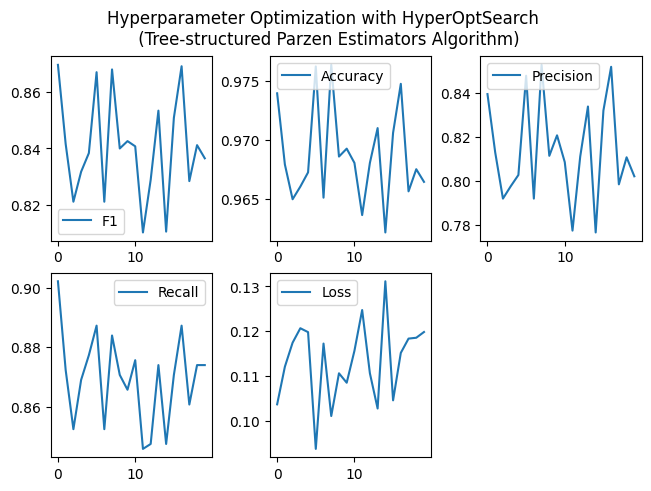

In [113]:
import matplotlib.pyplot as plt
import os

# Get the best trial result
best_result = analysis_object.get_best_trial(metric="eval_f1",mode="max")

# Print `log_dir` where checkpoints are stored
print('Best result logdir:', best_result.logdir)

# Print the best trial `config` reported at the last iteration
print('Best final iteration hyperparameter config:', best_result.config)

fig, axs = plt.subplots(2, 3, layout='constrained')
axs[0,0].plot(df_optimization.index, df_optimization["eval_f1"], label = "F1")
axs[0,0].legend()
axs[0,1].plot(df_optimization.index, df_optimization["eval_accuracy"], label = "Accuracy")
axs[0,1].legend()
axs[0,2].plot(df_optimization.index, df_optimization["eval_precision"], label = "Precision")
axs[0,2].legend()
axs[1,0].plot(df_optimization.index, df_optimization["eval_recall"], label = "Recall")
axs[1,0].legend()
axs[1,1].plot(df_optimization.index, df_optimization["eval_loss"], label = "Loss")
axs[1,1].legend()
axs[1,2].set_visible(False)

plt.xlim([0,20])
fig.suptitle("Hyperparameter Optimization with HyperOptSearch \n (Tree-structured Parzen Estimators Algorithm)")
plt.show()

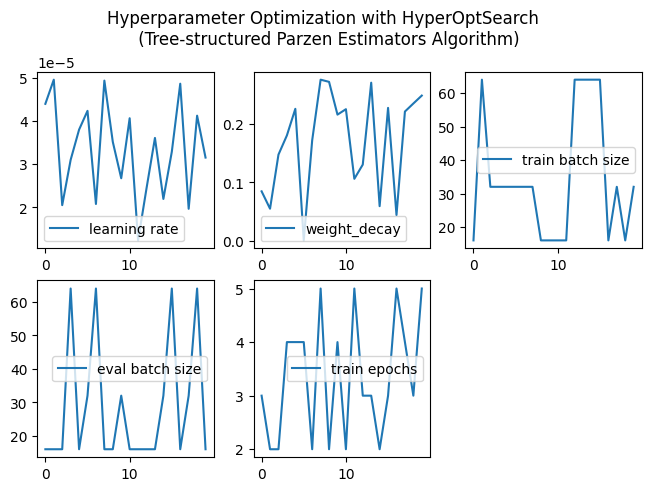

In [111]:
fig, axs = plt.subplots(2, 3, layout='constrained')
axs[0,0].plot(df_optimization.index, df_optimization["config/learning_rate"], label = "learning rate")
axs[0,0].legend()
axs[0,1].plot(df_optimization.index, df_optimization["config/weight_decay"], label = "weight_decay")
axs[0,1].legend()
axs[0,2].plot(df_optimization.index, df_optimization["config/per_device_train_batch_size"], label = "train batch size")
axs[0,2].legend()
axs[1,0].plot(df_optimization.index, df_optimization["config/per_device_eval_batch_size"], label = "eval batch size")
axs[1,0].legend()
axs[1,1].plot(df_optimization.index, df_optimization["config/num_train_epochs"], label = "train epochs")
axs[1,1].legend()
axs[1,2].set_visible(False)

plt.xlim([0,20])
fig.suptitle("Hyperparameter Optimization with HyperOptSearch \n (Tree-structured Parzen Estimators Algorithm)")
plt.show()


In [110]:
# show best run
best_trial.hyperparameters

{'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 16,
 'num_train_epochs': 3,
 'learning_rate': 4.3918345266035816e-05,
 'weight_decay': 0.08486048763759228}

In [114]:
# load the best trial parameters into the trainer
for n, v in best_trial.hyperparameters.items():
  setattr(trainer.args, n, v)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
24,0.132900,0.115933,0.847078,0.818885,0.877280,0.968700
48,0.073500,0.099674,0.867430,0.856220,0.878939,0.975416
72,0.053000,0.098076,0.866450,0.851200,0.882255,0.973401
96,0.041100,0.103729,0.869704,0.839506,0.902156,0.973939


TrainOutput(global_step=96, training_loss=0.07511878696580727, metrics={'train_runtime': 17.7052, 'train_samples_per_second': 84.721, 'train_steps_per_second': 5.422, 'total_flos': 61213573662120.0, 'train_loss': 0.07511878696580727, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
# info about trainer log history
metrics_train=trainer.state.log_history
for item in metrics_train:
  print(item)